#  Democracy of the Trees: How Ensembling Reduces Variance in Decision Forests

## Eric Hullander

<figure>
          <img src = 'https://poetkatehutchinson.files.wordpress.com/2012/09/treebeard1.jpg'              style="width:300px;height:300px" align = left>
</figure>

#### “Side? I am on nobody's side, because nobody is on my side, little orc.”  - Treebeard

Given a dataset and a target variable, there are many methods for finding a mapping (model) between the dataset and the target variable, and in the discipline of machine learning this process is called ‘supervised learning’.  There are two types of supervised learning, regression when our target is numerical, and classification when our target variable is categorical. Among these, there are many types of learners and each learner has its own set of strengths and weaknesses. Some attributes we would like our learner to have are: 

#### Qualities of a good Learner

-	Interpretability: Why did the model choose this result?  
-	Accuracy:   
    -	Are the predictions correct?   
    -	Does the model generalize to new data?  
-	Efficiency:   
    -	How long does it take to train this model?  
    -	Does it require lots of data  
-	Dimensionality:   
    -	Robust to Irrelevancy: Do we have to perform feature selection or reduce dimensionality to obtain a good model?  
    -	Robust to Collinearity: Will collinear variables compromise accuracy or interpretability?  
-	Robust to Scaling:  Will scaling or transforming the data affect the results?  

Unfortunately, we cannot always get everything we want, so when choosing a learner we must ask what kind of data we have and what questions we are trying to answer.

#### The decision trees have many of these qualities.

- Interpretability: We can see where splits are made 
- Accuracy: Decision trees are accurate on average (low bias), but highly dependent on the sample (high variance).  So they cannot be trusted on an individual basis
- Efficiency:  Greedy algorithm is O(C n log n) where C are number of features and n are number of samples.
- Robust to Dimensionality:  Dimensionality does not compromise accuracy
- Robust to Irrelevancy: Trees perform automatic feature selection based on GINI impurity or information gain.  Irrelevant features just aren’t used
- Robust to Collinearity: If two variables are collinear, the model can use one or the other.  This doesn't affect accuracy, but may compromise interpretability
- Robust to Scaling:  Scaling and many transformations e.g. log(x) would not affect where the tree splits if using GINI impurity or information gain.

<img src = "http://i.stack.imgur.com/r7QFy.png" style="width:300px;height:300px" align = left>

http://scott.fortmann-roe.com/docs/BiasVariance.html

Look at the upper right target in Fig. 1 and imagine these points were obtained by looking at the predictions, $X_i$ of *n* different trees. Let's assume that these trees are i.i.d, i.e. *independant and identically distributed* and have a mean accuracy *p*.  This accuracy may be high (low bias), but the spread of the predictions appear to still be wide (high variance). We may calculate this variance by asking about what the probability mass function (pmf) of this process looks like.  Since we constrained the trees to be independent, we can easily calculate the probability of combinations of successes and failures.  For example, the probability that all *n* trees are correct is $$p^n$$ while the probability that all *n* trees are incorrect is  $$(1-p)^n$$ in general,the probability of *k* trees being correct is 

eq 1. $${n \choose k}p^k (1-p)^{(n-k)}$$  This is a binomial distribution.  

Not being satisfied with a bunch of weak predictors, we ask what happens if we ensemble our trees by simply averaging the results?  On average, every tree that predicts too far north, there should be another tree too far south to average it out reducing our variance.

eq. 2. $$Y = \sum\limits_{i=0}^{n}\frac{1}{n}X_i$$  

Below we plot the distribution with different numbers of trees.  As can be seen in the plot 1, the variance appears to decrease with more trees.  An intuitive result and desirable result!  More trees means we are more confident in our predictions

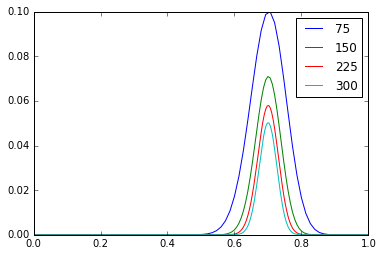

In [78]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import comb
for n in xrange(1,5):
    x, y, p = [], [], .05
    p = .7
    #N is number of trees
    N = 75*n
    #k is number of correct trees
    for k in xrange(0,N+1):
        x.append(1.0*k/N)
        y.append(comb(N,k)*(p**k)*((1-p)**(N-k)))
    plt.plot(x,y, label = N)
    plt.legend()

We can compute the variance of these distributions out-right by multiplying eq., the probability of *k* estimators being correct by the squared error when only *k* estimators are correct $(\frac{k}{n} - p)^2$


eq. 3. $$\sigma^2_Y = var(Y) = \sum\limits_{k=0}^{n}{n \choose k}p^k (1-p)^{(n-k)} (\frac{k}{n} - p)^2$$

Alternatively we could employ the following theorem:

Suppose $X_1, X_2, ... , X_n$ are n independent random variables with means $\mu_1,\mu_2,⋯,\mu_n $and variances $\sigma_1,\sigma_2,⋯,\sigma_n $. 

Then, the mean and variance of the linear combination $Y = \sum\limits_{i=1}^{n} a_i X_i$, where a1, a2, ... , an are real constants are:

eq. 3.  $$\mu_Y = \sum\limits_{i=1}^{n} a_i \mu_i$$
eq. 4.  $$\sigma^2_Y = \sum\limits_{i=1}^{n} a^2_i \sigma^2_i$$

https://onlinecourses.science.psu.edu/stat414/node/166

Substituting $a_i= \frac{1}{n}$ and $\sigma_i = \sigma_X$, because iid, gives

eq. 5.  $$\sigma^2_Y = \frac{\sigma^2_X}{n}$$

So we see that variance of *Y* decreases monotonically with the number of trees, *n*.  Below we plot eq 3 and 5 against n and see that they are appear equivalent qualitatively.  As an exercise, prove eq. 3 equals eq. 5.

In [79]:
'''
From eq. 3
[wins and losses example], 
number of wins, 
number of combinations, 
probability of number of wins, 
distance from mean'''
result = []

for N in range(1,50):
    tot = 0
    for k in range(N + 1):
        x = np.hstack((np.zeros(N-k), np.ones(k)))
        #print x, k, comb(N,k), ((p**k)*((1-p)**(N-k))), (1.0*k/N - p)
        tot += (comb(N,k)*((p**k)*((1-p)**(N-k))))*(1.0*k/N - p)**2
    result.append(tot)

In [80]:
'''
From eq. 5
'''
result2 = 1.0*p*(1-p)/np.array(range(1,50))

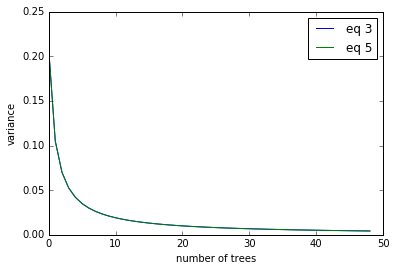

In [88]:
plt.xlabel('number of trees')
plt.ylabel('variance')
plt.plot(result, label = 'eq 3')
plt.plot(result2, label = 'eq 5')
plt.legend()

Since we are dealing with a sum of iid random variables we could envoke the central limit theorem <a href = 'https://en.wikipedia.org/wiki/Central_limit_theorem'>CLT</a>.  This says that even though the distribution of our random variable *X* is not normally distributed, the distribution of sample means will be normally distributed.  This can then allow us to compute how confident we are in our prediction.  

$$\lgroup\bar{x} \pm t^*\frac{s}{\sqrt{n}}\rgroup$$

where *s* is the Bessel correct sample standard deviation, and *t* is the t-score for a given confidence interval

https://en.wikipedia.org/wiki/Confidence_interval#Basic_steps

So this is all well and good but it only works if our initial assumption holds, that is each tree is iid.  How can this be if all trees are grown from the same data using the same rules?  It can't!  So what can be done?  To de-correlate the trees we grow each tree on a different subset of the data.  Each tree sees a random subset of the samples, a technique called
*<a href = "https://en.wikipedia.org/wiki/Bootstrap_aggregating">bagging</a>*, and a random subset of features, the *<a href = https://en.wikipedia.org/wiki/Random_subspace_method>random subspace method</a>*.  A rule of thumb is that the number of features used to grow each tree be equal to the square root of the number of total features.  This leads to a dilemma.  Fewer features may result in high bias, trees that are *on average* not good, while selecting more features will result in highly correlated trees and high variance.

In general random forests have proven to be a great tool for data scientists.  Now with a little more knowledge about the ideas behind random forests we can use them to greater affect.  In a future blog post we will continue to explore how to tune the hyperparameters of a random forest and how to interpret or "clear-box" the results...

Happy Learning!

References:

http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf  
http://ect.bell-labs.com/who/tkh/publications/papers/df.pdf
http://statweb.stanford.edu/~tibs/ElemStatLearn/
http://link.springer.com/article/10.1023%2FA%3A1010933404324